In [19]:
import osmnx as ox

chula = ox.graph_from_address('Chulalongkorn University, Bangkok, Thailand', distance=1000)
# chula = ox.project_graph(chula)

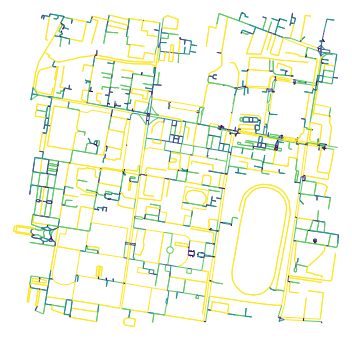

(<Figure size 460.398x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11cfeb2b0>)

In [23]:
ox.plot_graph(chula, node_size=0, edge_color=ox.get_edge_colors_by_attr(chula, attr='length'))

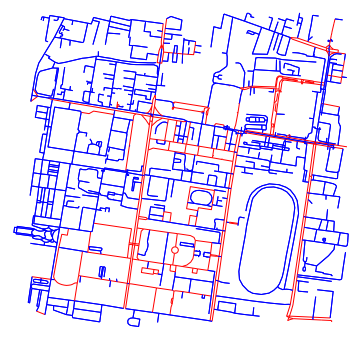

(<Figure size 448.647x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11db85898>)

In [16]:
ox.plot_graph(chula, node_size=0, edge_color=['r' if data['oneway'] else 'b' for u, v, key, data in chula.edges(keys=True, data=True)])

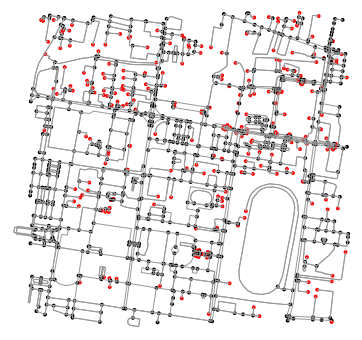

(<Figure size 448.647x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c724ba8>)

In [17]:
culdesacs = [key for key, value in chula.graph['streets_per_node'].items() if value==1]
nc = ['r' if node in culdesacs else 'none' for node in chula.nodes()]
ox.plot_graph(chula, node_color=nc)

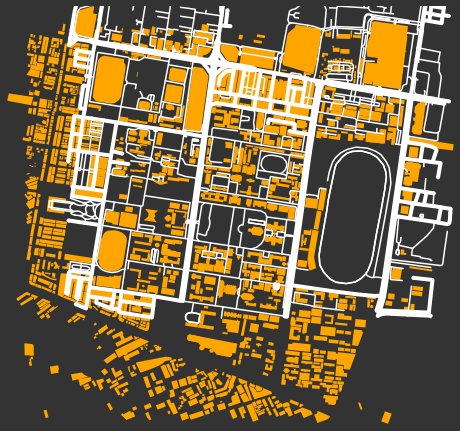

In [28]:
point = (13.738737, 100.531013)
dist = 1000
# graph = ox.graph_from_point(point, distance=dist)
# graph_proj = ox.project_graph(graph)
gdf = ox.buildings_from_point(point=point, distance=dist)
gdf_proj = ox.project_gdf(gdf)
fig, ax = ox.plot_figure_ground(G=chula, dist=dist, network_type='drive')
fig, ax = ox.plot_buildings(gdf_proj, fig=fig, ax=ax, color='orange')
fig

In [29]:
# chula_proj = ox.project_graph(chula)
extended_stats = ox.extended_stats(chula, ecc=True, bc=True, cc=True)
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(1692124205, 0.16557689590279487)

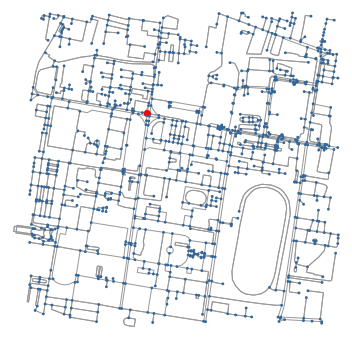

(<Figure size 460.398x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11be22860>)

In [30]:
nc = ['r' if node==max_node else '#336699' for node in chula.nodes()]
ns = [50 if node==max_node else 8 for node in chula.nodes()]
ox.plot_graph(chula, node_size=ns, node_color=nc, node_zorder=2)

In [32]:
chula_nodes = ox.graph_to_gdfs(chula, edges=False)
x, y = chula_nodes['geometry'].unary_union.centroid.xy
chula_center = ox.get_nearest_node(chula, (y[0], x[0]))
for u, v, k, data in chula.edges(data=True, keys=True):
    data['time'] = data['length'] / 75

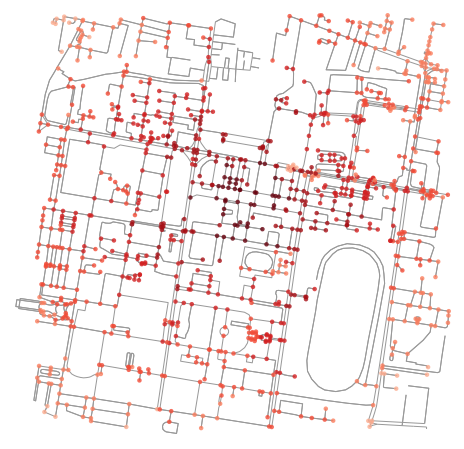

(<Figure size 613.864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11e8ee390>)

In [37]:
import networkx as nx
trip_times = [30, 25, 20, 15, 10, 5]
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
node_colors = {}
for trip_time, color in zip(trip_times, iso_colors):
    subgraph = nx.ego_graph(chula, chula_center, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in chula.nodes()]
ns = [20 if node in node_colors else 0 for node in chula.nodes()]
ox.plot_graph(chula, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

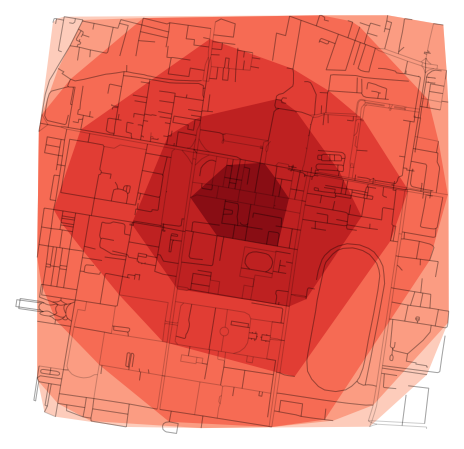

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from descartes import PolygonPatch

isochrone_polys = []
for trip_time in trip_times:
    subgraph = nx.ego_graph(chula, chula_center, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
fig, ax = ox.plot_graph(chula, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()